# Import Libraries

In [11]:
%%capture
!pip install pyDOE

In [12]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# *Data Prep*

Training and Testing data is prepared from the solution file

In [13]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2)

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [14]:
# Test data for the boundary conditions
# Flatten the X and Y grids column-wise ('F' order for Fortran-like indexing) and combine them into a 2D array
X_u_test = np.hstack((X.flatten(order='F')[:, None], Y.flatten(order='F')[:, None]))

# Domain bounds
lb = np.array([-1, -1])  # Lower bound for the domain in both dimensions (x and y)
ub = np.array([1, 1])    # Upper bound for the domain in both dimensions (x and y)

# Constants for the wave equation or PDE parameters
a_1 = 1  # Coefficient for the sine term in the x-dimension
a_2 = 1  # Coefficient for the sine term in the y-dimension
k = 1    # Constant parameter, often related to wave number

# Analytical solution of the PDE (sinusoidal) chosen for convenience
# sin(a_1 * pi * x) * sin(a_2 * pi * y) generates a 2D sine wave solution
usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y)

# Flatten the solution array in column-major order ('F') and reshape it into a column vector
u_true = usol.flatten('F')[:, None]

# Training Data

In [15]:
def trainingdata(N_u, N_f):
    """
    Generates training data for boundary conditions and collocation points.

    This function assembles the training data from the boundary edges of a solution grid
    and generates random collocation points using Latin Hypercube Sampling (LHS).
    It selects a specified number of training points from the boundary conditions
    and creates collocation points for training a PDE-based model.

    Parameters
    ----------
    N_u : int
        The number of boundary condition points to select for training.
    N_f : int
        The number of collocation points to generate using Latin Hypercube Sampling.

    Returns
    -------
    X_f_train : numpy.ndarray
        Array containing the collocation points (and boundary points).
    X_u_train : numpy.ndarray
        Array containing the selected boundary points.
    u_train : numpy.ndarray
        Array containing the corresponding boundary condition values.

    Notes
    -----
    - The function uses random sampling from the boundary data, so each run may return
      different training points.
    - The collocation points are generated in a 2D space using Latin Hypercube Sampling.
    """

    # Extract left edge boundary points for x and corresponding u values
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_u = usol[:, 0][:, None]

    # Extract right edge boundary points for x and corresponding u values
    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_u = usol[:, -1][:, None]

    # Extract top edge boundary points for x and corresponding u values
    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_u = usol[0, :][:, None]

    # Extract bottom edge boundary points for x and corresponding u values
    bottomedge_x = np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    bottomedge_u = usol[-1, :][:, None]

    # Combine all edge points into one array
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])

    # Randomly select N_u points for training from the boundary data
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    # Select the corresponding training points and u values
    X_u_train = all_X_u_train[idx[0:N_u], :]  # Boundary points (x, t)
    u_train = all_u_train[idx[0:N_u], :]      # Corresponding u values

    """ Collocation Points """

    # Latin Hypercube Sampling for generating N_f collocation points
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Generates points in the domain [lb, ub]

    # Append training points to the collocation points
    X_f_train = np.vstack((X_f, X_u_train))

    return X_f_train, X_u_train, u_train

# Physics Informed Neural Network

In [16]:
class SequentialModel(nn.Module):
    """
    A custom sequential neural network model for solving boundary condition (BC) and
    partial differential equation (PDE) loss functions using PyTorch.

    Parameters
    ----------
    layers : list
        A list defining the number of nodes in each layer of the network.
    """

    def __init__(self, layers):
        """
        Initializes the SequentialModel with the specified layers, activation function,
        loss function, and weight initialization.

        Parameters
        ----------
        layers : list
            A list of integers where each element defines the number of neurons
            in the respective layer.
        """
        super().__init__()  # Call the parent class (nn.Module) initializer

        # Tanh activation function
        self.activation = nn.Tanh()

        # Mean squared error (MSE) loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # Initialize the network as a list of linear layers
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        # Xavier normal initialization for weights and setting biases to zero
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        """
        Forward pass through the network. Scales the input features and passes them through
        the layers of the model, applying the activation function after each layer.

        Parameters
        ----------
        x : torch.Tensor or numpy array
            Input tensor or array to be processed.

        Returns
        -------
        torch.Tensor
            Output of the model.
        """
        # Convert numpy array to tensor if needed
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)

        # Convert lower and upper bounds to tensors
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        # Feature scaling
        x = (x - l_b) / (u_b - l_b)

        # Convert input to float
        a = x.float()

        # Pass through each linear layer with activation
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)

        # Final layer without activation
        a = self.linears[-1](a)

        return a

    def loss_BC(self, x, y):
        """
        Computes the boundary condition (BC) loss using MSE between the model's predictions
        and ground truth.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.
        y : torch.Tensor
            Ground truth tensor.

        Returns
        -------
        torch.Tensor
            Loss value for the boundary condition.
        """
        return self.loss_function(self.forward(x), y)

    def loss_PDE(self, x_to_train_f):
        """
        Computes the partial differential equation (PDE) loss using automatic differentiation
        to calculate the second-order derivatives.

        Parameters
        ----------
        x_to_train_f : torch.Tensor
            Input tensor for training PDE.

        Returns
        -------
        torch.Tensor
            Loss value for the PDE.
        """
        x_1_f = x_to_train_f[:, [0]]
        x_2_f = x_to_train_f[:, [1]]

        g = x_to_train_f.clone()
        g.requires_grad = True

        # Forward pass through the network
        u = self.forward(g)

        # Compute first-order derivatives
        u_x = autograd.grad(u, g, torch.ones([x_to_train_f.shape[0], 1]).to(device),
                            retain_graph=True, create_graph=True)[0]

        # Compute second-order derivatives
        u_xx = autograd.grad(u_x, g, torch.ones(x_to_train_f.shape).to(device),
                             create_graph=True)[0]
        u_xx_1 = u_xx[:, [0]]
        u_xx_2 = u_xx[:, [1]]

        # Define the PDE residual
        q = (-(a_1 * np.pi) ** 2 - (a_2 * np.pi) ** 2 + k ** 2) * \
            torch.sin(a_1 * np.pi * x_1_f) * torch.sin(a_2 * np.pi * x_2_f)
        f = u_xx_1 + u_xx_2 + k ** 2 * u - q

        # PDE loss
        return self.loss_function(f, f_hat)

    def loss(self, x, y, x_to_train_f):
        """
        Computes the total loss by combining boundary condition (BC) loss and
        partial differential equation (PDE) loss.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor for BC.
        y : torch.Tensor
            Ground truth tensor for BC.
        x_to_train_f : torch.Tensor
            Input tensor for PDE.

        Returns
        -------
        torch.Tensor
            Total loss value.
        """
        loss_u = self.loss_BC(x, y)
        loss_f = self.loss_PDE(x_to_train_f)

        return loss_u + loss_f

    def closure(self):
        """
        Defines the closure function for the optimizer to minimize the loss. This function is
        used during the optimization process.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        optimizer.zero_grad()

        # Compute total loss
        loss_val = self.loss(X_u_train, u_train, X_f_train)

        # Test the model and get error metrics
        error_vec, _ = self.test()

        print(loss, error_vec)

        # Backpropagation
        loss_val.backward()

        return loss_val

    def test(self):
        """
        Tests the model on the test data and computes the relative L2 norm of the error.

        Returns
        -------
        error_vec : torch.Tensor
            The relative L2 norm of the error.
        u_pred : numpy.ndarray
            The predicted output reshaped as a 2D array.
        """
        # Model prediction on test data
        u_pred = self.forward(X_u_test_tensor)

        # Compute relative L2 norm of the error
        error_vec = torch.linalg.norm((u - u_pred), 2) / torch.linalg.norm(u, 2)

        # Reshape the predicted output to a 2D array
        u_pred = np.reshape(u_pred.cpu().detach().numpy(), (256, 256), order='F')

        return error_vec, u_pred

# *Solution Plot*

In [17]:
def solutionplot(u_pred, X_u_train, u_train):
    """
    Plots the ground truth solution, predicted solution, and absolute error between them.

    Parameters
    ----------
    u_pred : numpy.ndarray
        Predicted solution values from the model.
    X_u_train : numpy.ndarray
        Training points used for boundary conditions (not plotted but included for context).
    u_train : numpy.ndarray
        Corresponding boundary condition values (not plotted but included for context).
    """

    # Ground truth solution plot
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_1, x_2, usol, cmap='jet')  # Plot the ground truth solution 'usol' using a color map
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Predicted solution plot
    plt.subplot(1, 3, 2)
    plt.pcolor(x_1, x_2, u_pred, cmap='jet')  # Plot the predicted solution 'u_pred' using the same color map
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Absolute error plot
    plt.subplot(1, 3, 3)
    plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')  # Plot the absolute error between ground truth and prediction
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)

    plt.tight_layout()  # Adjust subplots to fit into the figure area cleanly

    # Save the figure as a high-resolution image file
    plt.savefig('Helmholtz_non_stiff.png', dpi=500, bbox_inches='tight')

# Main

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
tensor(84.4532, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0493, device='cuda:0', grad_fn=<DivBackward0>)
tensor(40.7814, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.1749, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19.4513, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.4607, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1742, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.4838, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3517, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.3446, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6005, device='cuda:0', grad_fn=<AddBackward0>) tensor(3.4120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3818, device='cuda:0', grad_fn=<

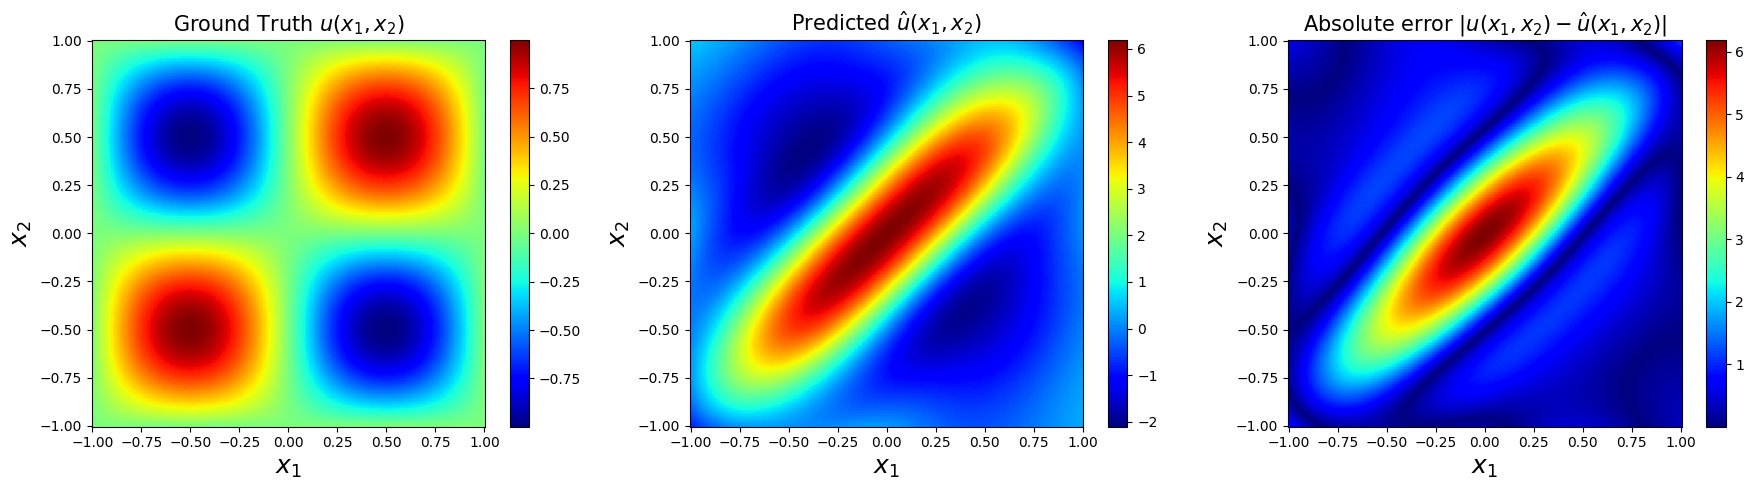

In [18]:
# Number of training points and collocation points
N_u = 400  # Total number of data points for 'u', used to train the model on boundary conditions
N_f = 10000  # Total number of collocation points for training the physics-informed part of the model

# Generate training data
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u, N_f)

# Convert the numpy arrays to PyTorch tensors and move them to the GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
u = torch.from_numpy(u_true).float().to(device)  # True solution values (ground truth for testing)
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the physics equation residual

# Neural network architecture definition
layers = np.array([2, 50, 50, 50, 1])  # Input layer with 2 nodes, 3 hidden layers with 50 nodes each, and an output layer with 1 node

# Initialize the neural network model
PINN = Sequentialmodel(layers)

# Move the model to the GPU (if available)
PINN.to(device)

# Print a summary of the neural network architecture
print(PINN)

# Store the parameters of the neural network for optimization
params = list(PINN.parameters())

# Optimization Section

# Uncomment the following section for L-BFGS optimizer if preferred
'''
L-BFGS Optimizer (currently commented out for possible use later)

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1,
                              max_iter=1000,
                              max_eval=None,
                              tolerance_grad=1e-06,
                              tolerance_change=1e-09,
                              history_size=100,
                              line_search_fn='strong_wolfe')

# Zero the gradient buffers before optimization
optimizer.zero_grad()

# Perform optimization using the closure method defined in the model
optimizer.step(PINN.closure)
'''

# Adam Optimizer
optimizer = optim.Adam(PINN.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

max_iter = 1000  # Number of iterations for optimization

start_time = time.time()  # Start the timer to measure training time

# Training loop
for i in range(max_iter):

    # Calculate the total loss (boundary condition loss + physics-informed loss)
    loss = PINN.loss(X_u_train, u_train, X_f_train)

    # Zero the gradient buffers of all parameters
    optimizer.zero_grad()

    # Backpropagation to calculate gradients
    loss.backward()

    # Update the model parameters using the optimizer
    optimizer.step()

    # Print loss and error every 10 iterations
    if i % (max_iter / 10) == 0:
        error_vec, _ = PINN.test()  # Evaluate the model on test data
        print(loss, error_vec)

# Measure the elapsed training time
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

# Evaluate the model accuracy on test data
error_vec, u_pred = PINN.test()
print('Test Error: %.5f' % (error_vec))

# Plot the ground truth, predicted solution, and error
solutionplot(u_pred, X_u_train, u_train)